## **Weed or Crop? Training a deep learning model to identify weed and crop species.**

In [1]:
# Mount google drive where files are located
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [31]:
# Set up 
import os
import keras

from keras import backend as K  
from keras import models
from keras import layers
from keras import optimizers

from keras.preprocessing.image import ImageDataGenerator

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import one_hot
from tensorflow.keras.applications import xception
from tensorflow.keras.preprocessing import image

import gc




In [39]:
# Define directories for training and test images
base_path = '/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/new-data'

train_data_path = os.path.join(base_path, 'train')
test_data_path = os.path.join(base_path, 'test')
val_data_path = os.path.join(base_path, 'validation')


In [40]:
# Look at which classes of weed or crop we have, these are the abbreviated names
species = os.listdir("/content/drive/MyDrive/Harper/3-C7082/Assignment/C7082-assignment/new-data/train")
print(species)

['bgs', 'chk', 'cls', 'cwd', 'cbl', 'wht', 'fhn', 'lsb', 'mze', 'smw', 'shp', 'sbt']


In [41]:
# define pretrained Xception base
pretrained_base = xception.Xception(input_shape=[150, 150, 3], include_top=False)
pretrained_base.trainable = False

In [51]:
# Create full model with new densely connected classifier
model = tf.keras.Sequential([
    pretrained_base, # this is the pretrained Xception base from above 
    tf.keras.layers.GlobalMaxPooling2D(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.BatchNormalization(trainable = True,axis=1),
    
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.BatchNormalization(trainable = True,axis=1),
    
    tf.keras.layers.Dense(12,activation='softmax') # this should be number of classes?
])



In [52]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 2048)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 100)               204900    
_________________________________________________________________
batch_normalization_12 (Batc (None, 100)               400       
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
batch_normalization_13 (Batc (None, 50)               

In [53]:
# Compile model with optimiser, loss and metrics
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = ['accuracy'])

In [54]:
# Rescale images 
train_datagen = ImageDataGenerator(rescale = 1/255)
val_datagen = ImageDataGenerator(rescale = 1/255)
test_datagen = ImageDataGenerator(rescale = 1/255)


In [55]:
# Generate images for model
print("Total images in training data set:")
train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

print("Total images in validation data set")
val_generator = val_datagen.flow_from_directory(
    val_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

print("Total images in test data set")
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size = (150, 150),
    color_mode = "rgb",
    classes = species,
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

Total images in training data set:
Found 4939 images belonging to 12 classes.
Total images in validation data set
Found 300 images belonging to 12 classes.
Total images in test data set
Found 300 images belonging to 12 classes.


In [56]:
# Fit the model using the training data
result = model.fit(train_generator,
                    epochs = 10,
                   verbose = 1,
                   validation_data = val_generator)

Epoch 1/10
155/155 [==============================] - 567s 4s/step - loss: 2.2510 - accuracy: 0.2847 - val_loss: 1.4657 - val_accuracy: 0.5133
Epoch 2/10
155/155 [==============================] - 493s 3s/step - loss: 1.4283 - accuracy: 0.5280 - val_loss: 1.1508 - val_accuracy: 0.5967
Epoch 3/10
155/155 [==============================] - 496s 3s/step - loss: 1.1543 - accuracy: 0.6157 - val_loss: 1.0763 - val_accuracy: 0.6100
Epoch 4/10
155/155 [==============================] - 495s 3s/step - loss: 1.0692 - accuracy: 0.6328 - val_loss: 1.1243 - val_accuracy: 0.5967
Epoch 5/10
155/155 [==============================] - 496s 3s/step - loss: 0.9799 - accuracy: 0.6601 - val_loss: 1.0404 - val_accuracy: 0.6233
Epoch 6/10
155/155 [==============================] - 491s 3s/step - loss: 0.9309 - accuracy: 0.6764 - val_loss: 1.0022 - val_accuracy: 0.6433
Epoch 7/10
155/155 [==============================] - 488s 3s/step - loss: 0.8402 - accuracy: 0.7221 - val_loss: 0.9413 - val_accuracy: 0.6600

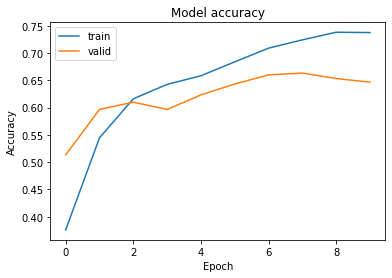

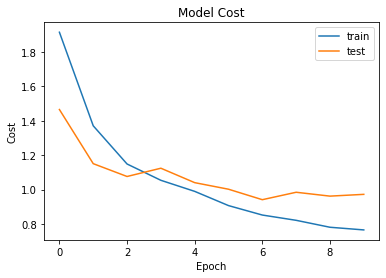

In [57]:
plt.plot(result.history['accuracy'], label='train')
plt.plot(result.history['val_accuracy'], label='valid')
plt.legend(loc='upper left')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()
plt.plot(result.history['loss'], label='train')
plt.plot(result.history['val_loss'], label='test')
plt.legend(loc='upper right')
plt.title('Model Cost')
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.show()

We have started by building a basic model, using the pretrained Xception base and a new classification layer.  It learns well with accuracy reaching over 70% and validation accuracy at 60%.


In [32]:
gc.collect()

1263

In [34]:

valid = model.evaluate(test_datagen.flow_from_directory(test_data_path,
                                                        target_size=(150, 150), 
                                                        color_mode='rgb',
                                                        class_mode='categorical',))

Found 100 images belonging to 4 classes.
4/4 [==============================] - 10s 2s/step - loss: 2.5358 - accuracy: 0.4800


In [36]:
a = test_datagen.flow_from_directory(test_data_path,
                                    target_size=(150, 150), 
                                    color_mode='rgb',
                                    class_mode='categorical',
                                    batch_size=1)

Found 100 images belonging to 4 classes.


In [37]:
species = list(a.class_indices.keys())

In [38]:
R_categories = {y:x for x,y in a.class_indices.items()}
R_categories

{0: 'bgs', 1: 'chk', 2: 'mze', 3: 'wht'}

In [ ]:
# Data Augmentation


----------

In [ ]:
img_width, img_height = 150, 150

size = (150, 150)

train_data_dir = train_data_dir.map(lambda x, y: (tf.image.resize(x, size), y))
validation_data_dir = validation_data_dir.map(lambda x, y: (tf.image.resize(x, size), y))
test_data_dir = test_data_dir.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:

epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), 
                        activation='relu',
                        input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3),
                        activation = 'relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

In [ ]:
train_features, train_labels = extract_features(train_dir, 4939)
validation_features, validation_labels = extract_features(validation_dir, 300)
test_features, test_labels = extract_features(test_dir, 300)

history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))